In [32]:
# imports
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt


In [37]:
# Settings
start_time = '2025-10-01 13:10:04.575 -05:00'

Animal device: TMPE5EE785B
Room device: TMP50E62832
Original filtered data1 shape: (4211, 1)
Original filtered data2 shape: (4505, 1)
Resampled data1 shape: (4689, 1)
Resampled data2 shape: (4596, 1)
Final merged data shape: (4023, 2)
Time range: 2025-10-01 13:10:04-05:00 to 2025-10-01 14:26:39-05:00
Covariance matrix:
[[0.05611804 0.00462808]
 [0.00462808 0.01027652]]

Correlation coefficient: 0.19272001477437434

Sample of merged data:
                           Temperature_dataset1  Temperature_dataset2
Timestamp                                                            
2025-10-01 13:10:04-05:00                21.953                34.125
2025-10-01 13:10:05-05:00                21.960                34.125
2025-10-01 13:10:06-05:00                21.953                34.132
2025-10-01 13:10:07-05:00                21.953                34.125
2025-10-01 13:10:08-05:00                21.968                34.125


C:\Users\NeuroLux1\AppData\Local\Temp\ipykernel_35412\2795405420.py:43: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  resampled_data1 = filtered_data1.resample(resample_freq).mean()
C:\Users\NeuroLux1\AppData\Local\Temp\ipykernel_35412\2795405420.py:44: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  resampled_data2 = filtered_data2.resample(resample_freq).mean()


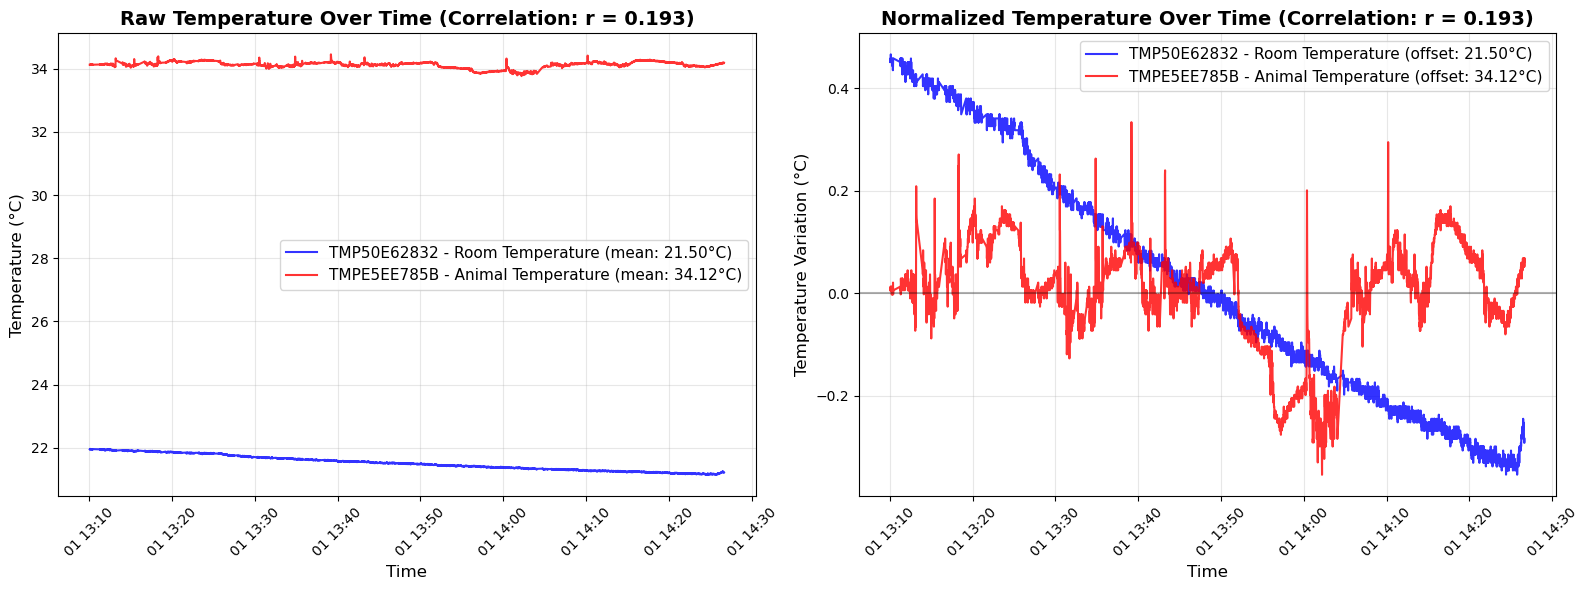


Temperature Statistics:
Room Temperature - Mean: 21.502°C, Std: 0.237°C
Animal Temperature - Mean: 34.119°C, Std: 0.101°C
DC Offset difference: -12.617°C

Raw Temperature Differences:

Normalized Temperature Differences (DC-removed):
Mean difference: -0.000°C
Std difference: 0.292°C
Max difference: 0.777°C
Min difference: -0.864°C


In [55]:



# Upload temperature data files
animal_filename = "20251001_T104037-05_TMPE5EE785B_Temp_0.csv"
room_filename = "20251001_T130656-05_TMP50E62832_Temp_0.csv"

# animal_filename = "20251001_T104032-05_TMPFD52FEC2_Temp_0.csv"
# animal_filename = "20251001_T130657-05_TMP2ADBEDE1_Temp_0.csv"



animal_data = pd.read_csv(animal_filename)
room_data = pd.read_csv(room_filename)

# Extract device names from filenames dynamically
import re
animal_device = re.search(r'TMP[A-F0-9]+', animal_filename).group()
room_device = re.search(r'TMP[A-F0-9]+', room_filename).group()

print(f"Animal device: {animal_device}")
print(f"Room device: {room_device}")

# Convert timestamp columns to datetime and set as index
animal_data['Timestamp'] = pd.to_datetime(animal_data['Timestamp'])
room_data['Timestamp'] = pd.to_datetime(room_data['Timestamp'])

# Set timestamp as index for resampling
animal_data = animal_data.set_index('Timestamp')
room_data = room_data.set_index('Timestamp')

# Grab start timestamp
start_timestamp = pd.to_datetime(start_time)

# Filter data after specified timestamp
filtered_data1 = room_data[room_data.index >= start_timestamp]
filtered_data2 = animal_data[animal_data.index >= start_timestamp]

print(f"Original filtered data1 shape: {filtered_data1.shape}")
print(f"Original filtered data2 shape: {filtered_data2.shape}")

# Resample both datasets to a common frequency (e.g., 1 second)
# You can adjust the frequency: '1S' (1 second), '100ms' (100 milliseconds), etc.
resample_freq = '1S'  # 1 second intervals

resampled_data1 = filtered_data1.resample(resample_freq).mean()
resampled_data2 = filtered_data2.resample(resample_freq).mean()

print(f"Resampled data1 shape: {resampled_data1.shape}")
print(f"Resampled data2 shape: {resampled_data2.shape}")

# Merge the resampled datasets
merged_data = pd.merge(resampled_data1, resampled_data2, 
                      left_index=True, right_index=True,
                      suffixes=('_dataset1', '_dataset2'))

# Remove rows where either dataset has NaN values (no data for that time period)
merged_data = merged_data.dropna()

print(f"Final merged data shape: {merged_data.shape}")
print(f"Time range: {merged_data.index.min()} to {merged_data.index.max()}")

# Calculate covariance between temperature columns
if len(merged_data) == 0:
    print("Warning: No matching timestamps found between datasets after resampling.")
    print("Try adjusting the start timestamp or resample frequency.")
else:
    temp_cov = np.cov(merged_data['Temperature_dataset1'], merged_data['Temperature_dataset2'])
    
    print("Covariance matrix:")
    print(temp_cov)
    
    #  Calculate correlation coefficient
    correlation = np.corrcoef(merged_data['Temperature_dataset1'], merged_data['Temperature_dataset2'])[0,1]
    print(f"\nCorrelation coefficient: {correlation}")
    
    # Show some sample data
    print(f"\nSample of merged data:")
    print(merged_data.head())
    
    # Create two plots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Calculate DC offsets (mean values) for normalization
    dc_offset1 = merged_data['Temperature_dataset1'].mean()
    dc_offset2 = merged_data['Temperature_dataset2'].mean()
    
    # Normalize temperatures by subtracting DC offsets
    temp1_normalized = merged_data['Temperature_dataset1'] - dc_offset1
    temp2_normalized = merged_data['Temperature_dataset2'] - dc_offset2
    
    # Plot 1: Raw temperature data over time
    ax1.plot(merged_data.index, merged_data['Temperature_dataset1'], 
             label=f'{room_device} - Room Temperature (mean: {dc_offset1:.2f}°C)', alpha=0.8, linewidth=1.5, color='blue')
    ax1.plot(merged_data.index, merged_data['Temperature_dataset2'], 
             label=f'{animal_device} - Animal Temperature (mean: {dc_offset2:.2f}°C)', alpha=0.8, linewidth=1.5, color='red')
    
    ax1.set_title(f'Raw Temperature Over Time (Correlation: r = {correlation:.3f})', 
                  fontsize=14, fontweight='bold')
    ax1.set_xlabel('Time', fontsize=12)
    ax1.set_ylabel('Temperature (°C)', fontsize=12)
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)
    
    # Plot 2: Normalized temperature data over time
    ax2.plot(merged_data.index, temp1_normalized, 
             label=f'{room_device} - Room Temperature (offset: {dc_offset1:.2f}°C)', alpha=0.8, linewidth=1.5, color='blue')
    ax2.plot(merged_data.index, temp2_normalized, 
             label=f'{animal_device} - Animal Temperature (offset: {dc_offset2:.2f}°C)', alpha=0.8, linewidth=1.5, color='red')
    
    ax2.set_title(f'Normalized Temperature Over Time (Correlation: r = {correlation:.3f})', 
                  fontsize=14, fontweight='bold')
    ax2.set_xlabel('Time', fontsize=12)
    ax2.set_ylabel('Temperature Variation (°C)', fontsize=12)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print some statistics
    print(f"\nTemperature Statistics:")
    print(f"Room Temperature - Mean: {merged_data['Temperature_dataset1'].mean():.3f}°C, Std: {merged_data['Temperature_dataset1'].std():.3f}°C")
    print(f"Animal Temperature - Mean: {merged_data['Temperature_dataset2'].mean():.3f}°C, Std: {merged_data['Temperature_dataset2'].std():.3f}°C")
    print(f"DC Offset difference: {dc_offset1 - dc_offset2:.3f}°C")
    print(f"\nRaw Temperature Differences:")
    # print(f"Mean difference: {temp_diff_raw.mean():.3f}°C")
    # print(f"Std difference: {temp_diff_raw.std():.3f}°C")
    # print(f"Max difference: {temp_diff_raw.max():.3f}°C")
    # print(f"Min difference: {temp_diff_raw.min():.3f}°C")
    print(f"\nNormalized Temperature Differences (DC-removed):")
    print(f"Mean difference: {temp_diff_normalized.mean():.3f}°C")
    print(f"Std difference: {temp_diff_normalized.std():.3f}°C")
    print(f"Max difference: {temp_diff_normalized.max():.3f}°C")
    print(f"Min difference: {temp_diff_normalized.min():.3f}°C")

In [ ]:
# Multi-file temperature analysis with file selection popup
import glob
import os
from tkinter import filedialog, Tk
import tkinter as tk

# Get all CSV files in the current directory
csv_files = glob.glob("*.csv")
print("Available CSV files in current directory:")
for i, file in enumerate(csv_files):
    print(f"{i}: {file}")

# Create file selection popup
def select_files():
    root = Tk()
    root.withdraw()  # Hide the main window
    
    # Open file dialog for multiple file selection
    selected_files = filedialog.askopenfilenames(
        title="Select Temperature Data Files",
        filetypes=[("CSV files", "*.csv"), ("All files", "*.*")],
        initialdir=os.getcwd()
    )
    
    root.destroy()
    return list(selected_files)

# Use file selection popup
print("\nOpening file selection dialog...")
selected_files = select_files()

if selected_files:
    print(f"\nSelected files for analysis:")
    for file in selected_files:
        print(f"✓ {os.path.basename(file)}")
    
    # Load all selected data
    data_dict = {}
    device_names = {}
    
    for file_path in selected_files:
        try:
            # Extract device name from filename
            filename = os.path.basename(file_path)
            device_name = re.search(r'TMP[A-F0-9]+', filename).group()
            device_names[file_path] = device_name
            
            # Load data
            df = pd.read_csv(file_path)
            df['Timestamp'] = pd.to_datetime(df['Timestamp'])
            df = df.set_index('Timestamp')
            
            # Filter data after start time
            filtered_df = df[df.index >= start_timestamp]
            data_dict[file_path] = filtered_df
            
            print(f"Loaded {device_name}: {len(filtered_df)} data points")
            
        except Exception as e:
            print(f"Error loading {os.path.basename(file_path)}: {e}")
    
    print(f"\nSuccessfully loaded {len(data_dict)} datasets")
    
# else:
#     print("No files selected. Using default files...")
#     # Fallback to default files if none selected
#     default_files = [
#         "20251001_T104037-05_TMPE5EE785B_Temp_0.csv",
#         "20251001_T130657-05_TMP2ADBEDE1_Temp_0.csv"
#     ]
    
#     data_dict = {}
#     device_names = {}
    
#     for file in default_files:
#         if file in csv_files:
#             device_name = re.search(r'TMP[A-F0-9]+', file).group()
#             device_names[file] = device_name
            
#             df = pd.read_csv(file)
#             df['Timestamp'] = pd.to_datetime(df['Timestamp'])
#             df = df.set_index('Timestamp')
            
#             filtered_df = df[df.index >= start_timestamp]
#             data_dict[file] = filtered_df
            
#             print(f"Loaded {device_name}: {len(filtered_df)} data points")


Available CSV files in current directory:
0: 20250925_T090129-05_TMP50E62832_Temp_0.csv
1: 20250925_T090241-05_TMP2ADBEDE1_Temp_0.csv
2: 20251001_T104032-05_TMPFD52FEC2_Temp_0.csv
3: 20251001_T104037-05_TMPE5EE785B_Temp_0.csv
4: 20251001_T130656-05_TMP50E62832_Temp_0.csv
5: 20251001_T130657-05_TMP2ADBEDE1_Temp_0.csv

Opening file selection dialog...

Selected files for analysis:
✓ 20251001_T104032-05_TMPFD52FEC2_Temp_0.csv
✓ 20251001_T104037-05_TMPE5EE785B_Temp_0.csv
✓ 20251001_T130656-05_TMP50E62832_Temp_0.csv
✓ 20251001_T130657-05_TMP2ADBEDE1_Temp_0.csv
Loaded TMPFD52FEC2: 5794 data points
Loaded TMPE5EE785B: 5753 data points
Loaded TMP50E62832: 4764 data points
Loaded TMP2ADBEDE1: 4769 data points

Successfully loaded 4 datasets


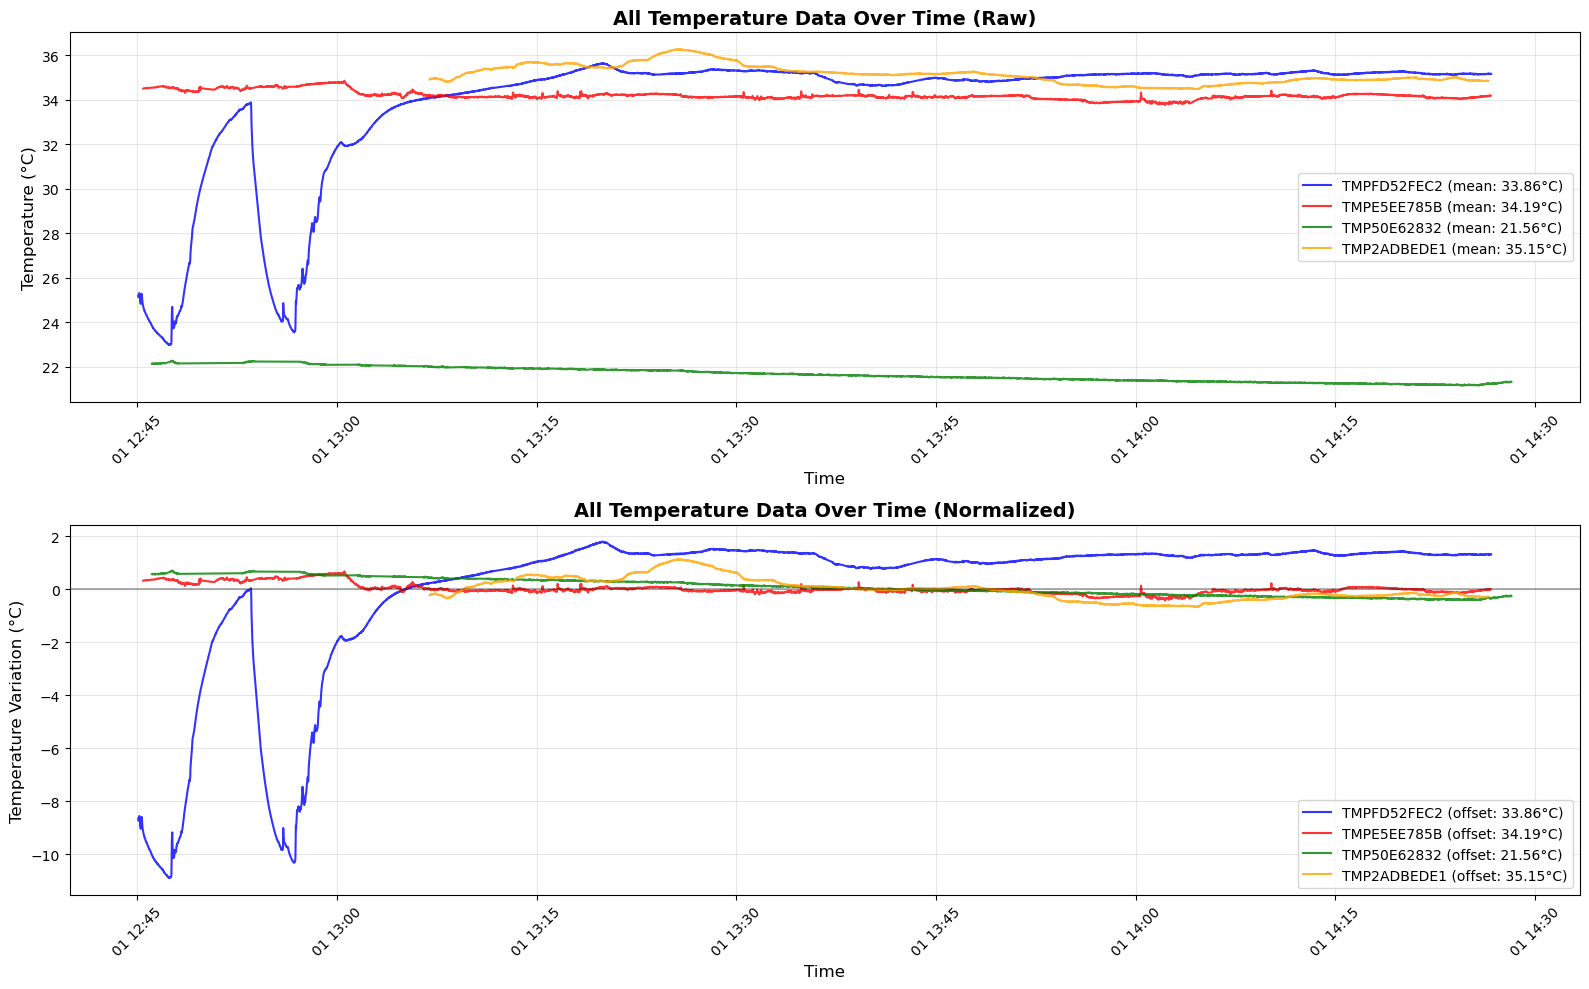


Correlation Matrix:
             TMPFD52FEC2  TMPE5EE785B  TMP50E62832  TMP2ADBEDE1
TMPFD52FEC2        1.000       -0.705       -0.525        0.088
TMPE5EE785B       -0.705        1.000        0.485        0.479
TMP50E62832       -0.525        0.485        1.000        0.732
TMP2ADBEDE1        0.088        0.479        0.732        1.000

Temperature Statistics:
TMPFD52FEC2: Mean=33.856°C, Std=2.933°C, Range=[22.968, 35.648]°C
TMPE5EE785B: Mean=34.189°C, Std=0.183°C, Range=[33.765, 34.859]°C
TMP50E62832: Mean=21.562°C, Std=0.292°C, Range=[21.148, 22.265]°C
TMP2ADBEDE1: Mean=35.149°C, Std=0.424°C, Range=[34.476, 36.281]°C


In [36]:
# Plot all selected temperature data
if len(data_dict) > 0:
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))
    
    # Define colors for different devices
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']
    
    # Plot raw temperatures
    for i, (file, df) in enumerate(data_dict.items()):
        device_name = device_names[file]
        color = colors[i % len(colors)]
        
        # Calculate mean for legend
        mean_temp = df['Temperature'].mean()
        
        ax1.plot(df.index, df['Temperature'], 
                label=f'{device_name} (mean: {mean_temp:.2f}°C)', 
                alpha=0.8, linewidth=1.5, color=color)
    
    ax1.set_title('All Temperature Data Over Time (Raw)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Time', fontsize=12)
    ax1.set_ylabel('Temperature (°C)', fontsize=12)
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)
    
    # Plot normalized temperatures
    for i, (file, df) in enumerate(data_dict.items()):
        device_name = device_names[file]
        color = colors[i % len(colors)]
        
        # Calculate DC offset and normalize
        dc_offset = df['Temperature'].mean()
        normalized_temp = df['Temperature'] - dc_offset
        
        ax2.plot(df.index, normalized_temp, 
                label=f'{device_name} (offset: {dc_offset:.2f}°C)', 
                alpha=0.8, linewidth=1.5, color=color)
    
    ax2.set_title('All Temperature Data Over Time (Normalized)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Time', fontsize=12)
    ax2.set_ylabel('Temperature Variation (°C)', fontsize=12)
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate correlations between all pairs
    print("\nCorrelation Matrix:")
    print("=" * 50)
    
    # Create a combined dataframe for correlation analysis
    temp_data = {}
    for file, df in data_dict.items():
        device_name = device_names[file]
        # Resample to 1 second intervals for consistent correlation analysis
        resampled = df.resample('1s').mean()
        temp_data[device_name] = resampled['Temperature']
    
    # Create correlation dataframe
    corr_df = pd.DataFrame(temp_data)
    corr_matrix = corr_df.corr()
    
    print(corr_matrix.round(3))
    
    # Show some statistics
    print(f"\nTemperature Statistics:")
    print("=" * 50)
    for file, df in data_dict.items():
        device_name = device_names[file]
        print(f"{device_name}: Mean={df['Temperature'].mean():.3f}°C, Std={df['Temperature'].std():.3f}°C, Range=[{df['Temperature'].min():.3f}, {df['Temperature'].max():.3f}]°C")

else:
    print("No data loaded. Please check your file selections.")
